In [1]:
import re
import glob
import json
import string
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from nltk.corpus import stopwords
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize

from wordcloud import WordCloud, ImageColorGenerator

In [2]:
'''create list of files with extension .json'''
jsons = glob.glob('jsons/*.json')

In [3]:
len(jsons)

987

In [4]:
'''get list of text reports from all .json files'''
reports = []
for jsn in jsons:
    with open(jsn, 'r') as j:
        reports.append(json.loads(j.read()))

In [5]:
'''remove "ReportText" from beginning of each report in reports.
   put all text in lowercase.
   tokenize each word in each report
   remove stopwords from each report
   remove all words with numbers from list'''
stop_words = set(stopwords.words('english'))

clean_reports = [report['ReportText'].lower() for report in reports]
clean_reports = [word_tokenize(report) for report in clean_reports]
clean_reports = [[word for word in report if word not in stop_words] for report in clean_reports]
clean_reports = [[word for word in report if word.isalpha()] for report in clean_reports] 

In [7]:
'''flatten list of lists into list of all unigrams'''
unigrams = sum(clean_reports, [])

In [8]:
'''create list of all bigrams from every report
   this expression can be adjusted and used for any size n-gram'''
bigrams = sum([[' '.join(report[i:i+2]) for i in range(len(report)-1)] for report in clean_reports], [])

In [9]:
'''how many total unigrams, how many unique unigrams'''
len(unigrams), len(set(unigrams))

(37829, 882)

In [10]:
'''how many total bigrams, how many unique bigrams'''
len(bigrams), len(set(bigrams))

(36842, 4186)

In [11]:
'''create dictionary of unigram and bigram counts'''
unigram_dict = dict(Counter(unigrams))
bigram_dict = dict(Counter(bigrams))

In [13]:
'''what bigrams have the highest probability with the lowest probability of the two words that comprise it?'''
bigram_probs = {}

for bigram in bigrams:
    first_word, last_word = bigram.split()
    bigram_probs[bigram] = bigram_dict[bigram] / (unigram_dict[first_word] + unigram_dict[last_word])
    
dict(sorted(bigram_probs.items(), key=lambda item: item[1], reverse=True))

{'episode care': 0.5,
 'shortness breath': 0.5,
 'zip code': 0.5,
 'habitus decreases': 0.5,
 'decreases sensitivity': 0.5,
 'sensitivity detect': 0.5,
 'referral consultation': 0.5,
 'consultation please': 0.5,
 'please call': 0.5,
 'medical imaging': 0.5,
 'sent review': 0.5,
 'oxygen tubing': 0.5,
 'sex acct': 0.5,
 'see discussion': 0.5,
 'transcriptionist printed': 0.5,
 'printed batch': 0.5,
 'traverses esophagus': 0.5,
 'esophagus ge': 0.5,
 'positive ppd': 0.5,
 'extrinsic compression': 0.5,
 'generator sequential': 0.5,
 'vena cava': 0.5,
 'attending physician': 0.5,
 'physician personally': 0.5,
 'covid exposure': 0.5,
 'technical factors': 0.5,
 'opportunity provide': 0.5,
 'including tracheostomy': 0.5,
 'paratracheal stripe': 0.5,
 'sore throat': 0.5,
 'shallow inspiration': 0.5,
 'feel like': 0.5,
 'shoulder arthroplasty': 0.5,
 'proper settings': 0.5,
 'valve stenosis': 0.5,
 'stenosis spec': 0.5,
 'spec inst': 0.5,
 'raise concern': 0.5,
 'inferior margin': 0.5,
 'non g

In [14]:
most_common_words = FreqDist(unigrams).most_common(100)
wordcloud = WordCloud(width=1600, 
                      height=800, 
                      background_color='white').generate(str(most_common_words))

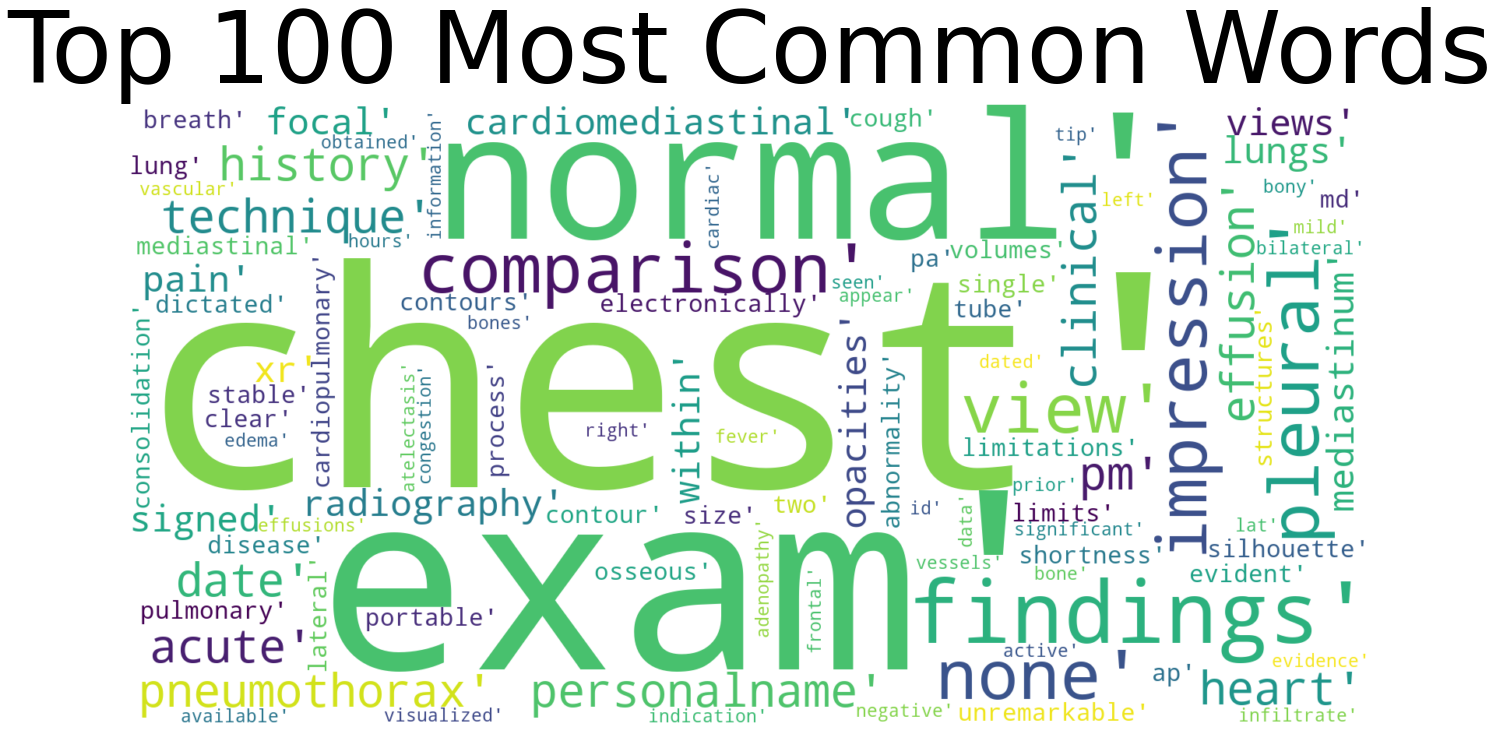

In [15]:
fig = plt.figure(figsize=(30,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 100 Most Common Words', fontsize=100)
plt.tight_layout(pad=0)
plt.show()

In [16]:
'''fields we are looking to parse'''
fields = ['exam', 'procedure', 'clinical', 'comparison', 'technique', 'findings', 'impression']

In [18]:
'''helper function to find index of first occurrence of field '''
def get_indices(report):
    indices = []
    for field in fields:
        try:
            indices.append(report.index(field))
        except ValueError:
            pass
    return sorted(indices)

In [20]:
field_dict = defaultdict(list)
sublists = []

for report in clean_reports:
    '''find index of first occurrence of each field in fields, sorted'''
    indices = get_indices(report)
    if len(indices) <= 1:
        field_dict['outliers'] = report
    else:
        '''break each report in to sublists split on field name'''
        for i in range(len(indices)-1):
            sublists.append(report[indices[i]:indices[i+1]])
        sublists.append(report[indices[-1]:])   

'''create dictionary with fields as keys, text as val'''
for sublist in sublists:
    field_dict[sublist[0]].append(sublist[1:])

In [21]:
'''create ANOTHER dictionary, with word counts for each field'''
fields_vocab = {}
for key in field_dict.keys():
    if key == 'outliers':
        fields_vocab[key] = dict(Counter(field_dict[key]))
    else:
        words = sum(field_dict[key], [])
        fields_vocab[key] = dict(Counter(words))
    

In [24]:
'''create dataframe from fields_vocab dict'''
field_df = pd.DataFrame.from_dict(fields_vocab)
field_df = field_df.fillna(0).astype('int32')
field_df['total'] = field_df.index.map(unigram_dict)

In [25]:
field_df

outliers  exam  clinical  comparison  technique  findings  \
chest            2  1002       237         317        228        88   
single           2    14         0           0         89        13   
view             2   224         2          42        375        23   
portable         2    27         0          62         37        29   
history          1   249       405          22          0         0   
...            ...   ...       ...         ...        ...       ...   
organism         0     0         0           0          0         0   
wording          0     0         0           0          0         0   
former           0     0         0           0          0         0   
document         0     0         0           0          0         0   
lead             0     0         0           0          0         0   

          impression  procedure  total  
chest            421         49   2459  
single           160          4    284  
view             163         18    880  
portable          11          8    186  
history            4          5    707  
...              ...        ...    ...  
organism           0          1      1  
wording            0          3      3  
former             0          1      1  
document           0          1      1  
lead               0          1      1  

[863 rows x 9 columns]

In [26]:
'''create dataframe of probabilities that a word is in that column'''
columns = [col for col in field_df.columns]
ratio_df = pd.DataFrame(columns=columns)
for column in columns:
    ratio_df[column] = field_df[column] / field_df['total']


In [27]:
ratio_df

outliers      exam  clinical  comparison  technique  findings  \
chest     0.000813  0.407483  0.096381    0.128914   0.092721  0.035787   
single    0.007042  0.049296  0.000000    0.000000   0.313380  0.045775   
view      0.002273  0.254545  0.002273    0.047727   0.426136  0.026136   
portable  0.010753  0.145161  0.000000    0.333333   0.198925  0.155914   
history   0.001414  0.352192  0.572843    0.031117   0.000000  0.000000   
...            ...       ...       ...         ...        ...       ...   
organism  0.000000  0.000000  0.000000    0.000000   0.000000  0.000000   
wording   0.000000  0.000000  0.000000    0.000000   0.000000  0.000000   
former    0.000000  0.000000  0.000000    0.000000   0.000000  0.000000   
document  0.000000  0.000000  0.000000    0.000000   0.000000  0.000000   
lead      0.000000  0.000000  0.000000    0.000000   0.000000  0.000000   

          impression  procedure  total  
chest       0.171208   0.019927    1.0  
single      0.563380   0.014085    1.0  
view        0.185227   0.020455    1.0  
portable    0.059140   0.043011    1.0  
history     0.005658   0.007072    1.0  
...              ...        ...    ...  
organism    0.000000   1.000000    1.0  
wording     0.000000   1.000000    1.0  
former      0.000000   1.000000    1.0  
document    0.000000   1.000000    1.0  
lead        0.000000   1.000000    1.0  

[863 rows x 9 columns]